<a href="https://colab.research.google.com/github/rodgpt/MAR_FUTURA/blob/main/NDSI/NDSI_Sites_Comparison_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook compares the NDSI and bio-anthro energy for different case study sites. It allows you to set a date range.

This notebook is structured to run locally (default) or on Google Colab.
To run on Colab:
1. Mount Google Drive.
2. Update the paths in the configuration cell to point to the Colab data folders.
3. Run the analysis cell, then the plots cell to save figures and tables.


In [ ]:
# @title Imports

from pathlib import Path
import os
import re
import sys
import time
from typing import Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal

try:
    import soundfile as sf
except Exception:
    sf = None

try:
    import librosa
except Exception:
    librosa = None


In [ ]:
# COLAB ONLY: stage audio from Drive to local disk

import os
import subprocess
from pathlib import Path

try:
    from google.colab import drive  # type: ignore

    drive.mount('/content/drive')

    # Drive paths (source of truth)
    dirs_sites_drive = {
        "San Antonio 38": Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/San Antonio/12-11-25/38"),
        "Ventanas 36": Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/Ventanas/07-11-25/36"),
        "Zapallar 34": Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/Zapallar/07-11-25/34"),
        "Las Cruces 26": Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/LasCruces/12-11-25/26"),
        "Matanzas 32": Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/Matanzas/13-11-25/32"),
    }

    output_dir = Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/NDSIResults")

    run_root = "/content/run_ndsi_sites"
    local_root = Path(run_root) / "sites"
    local_root.mkdir(parents=True, exist_ok=True)

    dirs_sites = {}
    for label, src in dirs_sites_drive.items():
        dst = local_root / label.replace("/", "_")
        dst.mkdir(parents=True, exist_ok=True)
        subprocess.run(
            [
                "rsync",
                "-a",
                "--info=progress2",
                "--prune-empty-dirs",
                "--include=*/",
                "--include=*.wav",
                "--include=*.WAV",
                "--exclude=*",
                str(src).rstrip("/") + "/",
                str(dst).rstrip("/") + "/",
            ],
            check=True,
        )
        dirs_sites[label] = dst

    output_dir.mkdir(parents=True, exist_ok=True)

    print("Staged sites to:", local_root)
    print("Outputs will be written to:", output_dir)

except Exception as e:
    # Not running in Colab
    pass


In [ ]:
# @title Configuration (LOCAL ONLY)

from pathlib import Path

# Set these only if you're running locally.
dirs_sites = {
    "San Antonio 38": Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/San Antonio/12-11-25/38"),
    "Ventanas 36": Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Ventanas/07-11-25/36"),
    "Zapallar 34": Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Zapallar/07-11-25/34"),
    "Las Cruces 26": Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/LasCruces/12-11-25/26"),
    "Matanzas 32": Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Matanzas/13-11-25/32"),
}
output_dir = Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults")

print('dirs_sites:', {k: str(v) for k, v in dirs_sites.items()})
print('output_dir:', output_dir)


PosixPath('/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults')

In [ ]:
# @title Configuration (COMMON - ALWAYS RUN)

# -----------------------------
# USER SETTINGS
# -----------------------------

segment_sec = 60
anthro_band = (1000, 2000) ##### changed to 100
bio_band = (2000, 3000)
tz = "UTC"

# sampling controls
files_per_hour = 4        # set None to use all
files_per_folder = None   # set an int to cap per folder

start_date = pd.Timestamp("2025-11-21 00:00:00", tz=tz)
end_date = pd.Timestamp("2025-11-29 23:59:59", tz=tz)

# -----------------------------
# VALIDATE PATHS
# -----------------------------

_required = ["dirs_sites", "output_dir"]
_missing = [k for k in _required if k not in globals() or not globals()[k]]
if _missing:
    raise RuntimeError(
        "Missing required variables from the Colab-only or Local-only config cell: " + ", ".join(_missing)
    )

output_dir = Path(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

_dirs_sites = {}
for k, v in dict(dirs_sites).items():
    _dirs_sites[str(k)] = Path(v)
dirs_sites = _dirs_sites

print('dirs_sites:', {k: str(v) for k, v in dirs_sites.items()})
print('output_dir:', output_dir)
print('segment_sec:', segment_sec)
print('anthro_band:', anthro_band)
print('bio_band:', bio_band)
print('files_per_hour:', files_per_hour)
print('files_per_folder:', files_per_folder)
print('start_date:', start_date)
print('end_date:', end_date)


Found 15612 files in San Antonio 38 (recursive)
Using 864 files in San Antonio 38 after filters
San Antonio 38: processed 25/864 files
San Antonio 38: processed 50/864 files
San Antonio 38: processed 75/864 files
San Antonio 38: processed 100/864 files
San Antonio 38: processed 125/864 files
San Antonio 38: processed 150/864 files
San Antonio 38: processed 175/864 files
San Antonio 38: processed 200/864 files
San Antonio 38: processed 225/864 files
San Antonio 38: processed 250/864 files
San Antonio 38: processed 275/864 files
San Antonio 38: processed 300/864 files
San Antonio 38: processed 325/864 files
San Antonio 38: processed 350/864 files
San Antonio 38: processed 375/864 files
San Antonio 38: processed 400/864 files
San Antonio 38: processed 425/864 files
San Antonio 38: processed 450/864 files
San Antonio 38: processed 475/864 files
San Antonio 38: processed 500/864 files
San Antonio 38: processed 525/864 files
San Antonio 38: processed 550/864 files
San Antonio 38: processed 5

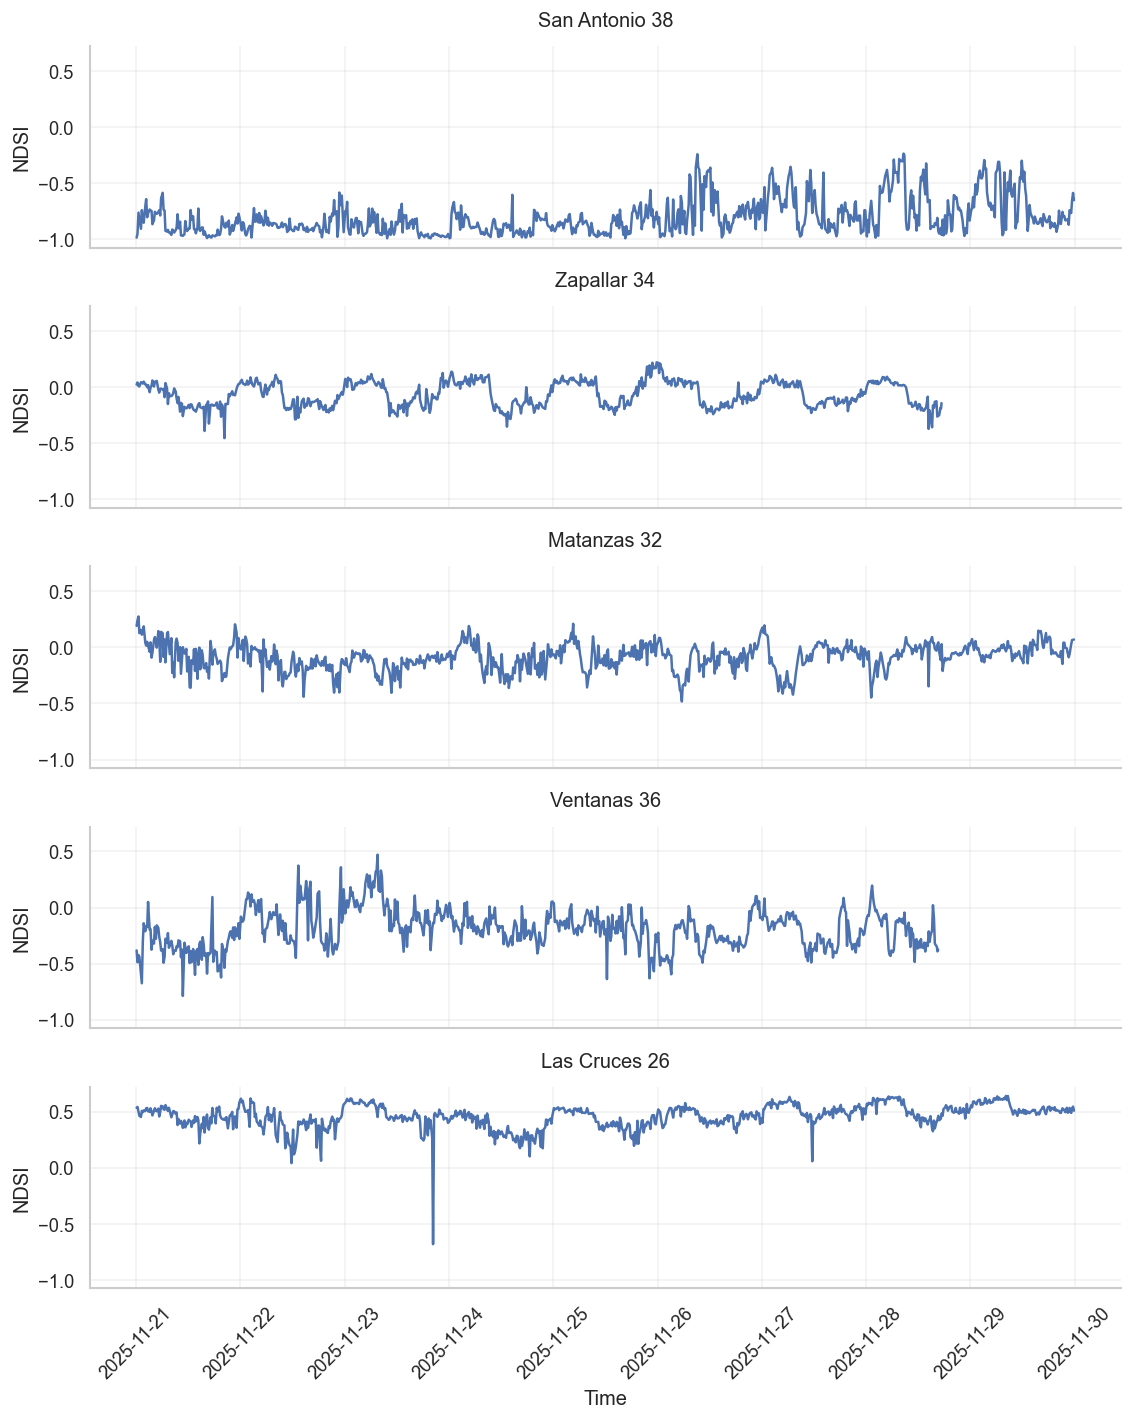

              Site NDSI_Quadrant  Segments  Total_Segments  Percent_Time
0    Las Cruces 26      (0, 0.5)       541             864     62.615741
1    Las Cruces 26    [-1, -0.5)         1             864      0.115741
2    Las Cruces 26      [0.5, 1]       322             864     37.268519
3      Matanzas 32      (0, 0.5)       196             864     22.685185
4      Matanzas 32     [-0.5, 0]       668             864     77.314815
5   San Antonio 38     [-0.5, 0]        65             864      7.523148
6   San Antonio 38    [-1, -0.5)       799             864     92.476852
7      Ventanas 36      (0, 0.5)       103             740     13.918919
8      Ventanas 36     [-0.5, 0]       621             740     83.918919
9      Ventanas 36    [-1, -0.5)        16             740      2.162162
10     Zapallar 34      (0, 0.5)       297             743     39.973082
11     Zapallar 34     [-0.5, 0]       446             743     60.026918


In [ ]:
# RUN (everything)
sns.set_theme(style="whitegrid")

# IMPORTANT: single backslashes inside a raw string. This must match filenames like:
# 20251121_180400.WAV or ST_1234_20251121_180400.WAV
_DT_RE = re.compile(r"^(?:ST_\d+_)?(\d{8}_\d{6})\.WAV$", re.IGNORECASE)


def extract_datetime(path: Path, tz: str = "UTC") -> pd.Timestamp:
    m = _DT_RE.match(path.name)
    if not m:
        raise ValueError(f"Filename does not match expected pattern: {path.name}")
    dt = pd.to_datetime(m.group(1), format="%Y%m%d_%H%M%S", utc=True)
    if tz.upper() == "UTC":
        return dt
    return dt.tz_convert(tz)


def read_wav_mono(path: Path, target_sr: Optional[int] = None):
    if sf is not None:
        audio, sr = sf.read(str(path), always_2d=True)
        audio = audio.mean(axis=1)
        if target_sr is not None and target_sr != sr:
            if librosa is None:
                raise RuntimeError("Resampling requested but librosa is not available")
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        return audio.astype(np.float32, copy=False), int(sr)

    if librosa is None:
        raise RuntimeError("Neither soundfile nor librosa is available to read WAV files")

    audio, sr = librosa.load(str(path), sr=target_sr, mono=True)
    return audio.astype(np.float32, copy=False), int(sr)


def calculate_ndsi_with_powers(audio: np.ndarray, sr: int, anthro_band, bio_band):
    # Islam-style: spectrogram -> mean power in each band -> (B-A)/(B+A)
    f, _, Sxx = signal.spectrogram(
        audio,
        sr,
        nperseg=2048,
        noverlap=1024,
        window="hann",
    )

    anthro_idx = np.where((f >= anthro_band[0]) & (f <= anthro_band[1]))[0]
    bio_idx = np.where((f >= bio_band[0]) & (f <= bio_band[1]))[0]

    if len(anthro_idx) == 0 or len(bio_idx) == 0:
        return {"ndsi": np.nan, "anthro_energy": np.nan, "bio_energy": np.nan}

    anthro_power = float(np.mean(Sxx[anthro_idx, :]))
    bio_power = float(np.mean(Sxx[bio_idx, :]))

    denom = bio_power + anthro_power
    if denom == 0 or not np.isfinite(denom):
        return {"ndsi": np.nan, "anthro_energy": anthro_power, "bio_energy": bio_power}

    ndsi = (bio_power - anthro_power) / denom
    return {"ndsi": float(ndsi), "anthro_energy": anthro_power, "bio_energy": bio_power}


def evenly_spaced_indices(n: int, k: int) -> np.ndarray:
    if k <= 0:
        return np.array([], dtype=int)
    if n <= k:
        return np.arange(n, dtype=int)
    idx = np.round((np.arange(1, k + 1) * (n + 1)) / (k + 1)).astype(int) - 1
    idx = np.clip(idx, 0, n - 1)
    return np.unique(idx)


def select_files(files):
    rows = []
    parse_fail = 0

    for p in files:
        try:
            dt = extract_datetime(p, tz=tz)
        except Exception:
            parse_fail += 1
            continue

        if start_date is not None and dt < (start_date - pd.Timedelta(seconds=segment_sec)):
            continue
        if end_date is not None and dt > end_date:
            continue
        rows.append((p, dt))

    if parse_fail > 0:
        print(f"Skipped {parse_fail} files due to filename parse mismatch")

    if not rows:
        return []

    df = pd.DataFrame(rows, columns=["path", "dt"]).sort_values("dt")

    if files_per_hour is not None:
        df["hour"] = df["dt"].dt.floor("h")
        picked = []
        for _, g in df.groupby("hour", sort=True):
            g = g.sort_values("dt")
            idx = evenly_spaced_indices(len(g), int(files_per_hour))
            picked.append(g.iloc[idx])
        df = pd.concat(picked, ignore_index=True)

    paths = df["path"].tolist()
    if files_per_folder is not None:
        paths = paths[: int(files_per_folder)]
    return paths


def process_site(directory: Path, label: str) -> pd.DataFrame:
    wavs = sorted([p for p in directory.rglob("*.WAV")] + [p for p in directory.rglob("*.wav")])
    print(f"Found {len(wavs)} files in {label} (recursive)")

    wavs = select_files(wavs)
    print(f"Using {len(wavs)} files in {label} after filters")

    out_rows = []

    for i, fp in enumerate(wavs, start=1):
        try:
            start_dt = extract_datetime(fp, tz=tz)
        except Exception:
            continue

        try:
            audio, sr = read_wav_mono(fp, target_sr=None)
        except Exception as e:
            print(f"Skipping unreadable file: {fp} ({e})")
            continue

        if audio.size == 0 or sr <= 0:
            continue

        dur_sec = audio.size / sr
        seg_len = min(segment_sec, dur_sec)
        if not np.isfinite(seg_len) or seg_len <= 0:
            continue

        max_start = max(0.0, dur_sec - seg_len)
        starts = np.arange(0.0, max_start + 1e-9, seg_len)

        for st in starts:
            segment_time = start_dt + pd.to_timedelta(float(st), unit="s")
            if start_date is not None and segment_time < start_date:
                continue
            if end_date is not None and segment_time > end_date:
                break

            i0 = int(round(st * sr))
            i1 = int(round((st + seg_len) * sr))
            seg = audio[i0:i1]
            if seg.size == 0:
                continue

            res = calculate_ndsi_with_powers(seg, sr, anthro_band, bio_band)
            out_rows.append(
                {
                    "Site": label,
                    "Time": segment_time,
                    "NDSI": res["ndsi"],
                    "Anthro_Energy": res["anthro_energy"],
                    "Bio_Energy": res["bio_energy"],
                }
            )

        if i % 25 == 0:
            print(f"{label}: processed {i}/{len(wavs)} files")

    return pd.DataFrame(out_rows)


all_results_list = []
for label, directory in dirs_sites.items():
    if not directory.exists():
        print(f"WARN: missing directory for {label}: {directory}")
        continue
    all_results_list.append(process_site(directory, label))

all_results = (
    pd.concat(all_results_list, ignore_index=True)
    if len(all_results_list) > 0
    else pd.DataFrame(columns=["Site", "Time", "NDSI", "Anthro_Energy", "Bio_Energy"])
)

if all_results.empty:
    raise RuntimeError("No results produced. Check directory paths, filename patterns, and date range.")

start_tag = start_date.strftime("%Y%m%d") if start_date is not None else "NA"
end_tag = end_date.strftime("%Y%m%d") if end_date is not None else "NA"
date_tag = f"{start_tag}-{end_tag}" if start_date is not None and end_date is not None else "alltime"
anthro_tag = f"anthro_{anthro_band[0]}-{anthro_band[1]}"
bio_tag = f"bio_{bio_band[0]}-{bio_band[1]}"

out_csv = output_dir / f"ndsi_casestudies_{date_tag}_{anthro_tag}_{bio_tag}.csv"
all_results.to_csv(out_csv, index=False)
print("Saved to:", out_csv)

summary_stats = (
    all_results.groupby("Site", as_index=False)
    .agg(
        Segments=("NDSI", "size"),
        Mean_NDSI=("NDSI", "mean"),
        SD_NDSI=("NDSI", "std"),
        Mean_Anthro_Energy=("Anthro_Energy", "mean"),
        SD_Anthro_Energy=("Anthro_Energy", "std"),
        Mean_Bio_Energy=("Bio_Energy", "mean"),
        SD_Bio_Energy=("Bio_Energy", "std"),
    )
    .sort_values("Site")
)
print(summary_stats)

print("NDSI outside [-1,1]:", int(((all_results["NDSI"] < -1) | (all_results["NDSI"] > 1)).sum()))
print("NAs:", all_results.isna().sum().to_dict())

plot_df = all_results.copy()
plot_df["Time"] = pd.to_datetime(plot_df["Time"], utc=(tz.upper() == "UTC"))
plot_df = plot_df.sort_values("Time")

g = sns.relplot(
    data=plot_df,
    x="Time",
    y="NDSI",
    col="Site",
    col_wrap=1,
    kind="line",
    height=2.4,
    aspect=4,
)

g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis="x", labelrotation=45)
plt.tight_layout()
plt.show()


def ndsi_quadrant(x: float):
    if not np.isfinite(x):
        return None
    if 0.5 <= x <= 1:
        return "[0.5, 1]"
    if 0 < x < 0.5:
        return "(0, 0.5)"
    if -0.5 <= x <= 0:
        return "[-0.5, 0]"
    if -1 <= x < -0.5:
        return "[-1, -0.5)"
    return None


qt = all_results.copy()
qt["NDSI_Quadrant"] = qt["NDSI"].map(ndsi_quadrant)
qt = qt.dropna(subset=["NDSI_Quadrant"])
qt = qt.groupby(["Site", "NDSI_Quadrant"], as_index=False).agg(Segments=("NDSI", "size"))
qt["Total_Segments"] = qt.groupby("Site")["Segments"].transform("sum")
qt["Percent_Time"] = 100.0 * qt["Segments"] / qt["Total_Segments"]
qt = qt.sort_values(["Site", "NDSI_Quadrant"])
print(qt)


Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/Graphs/ndsi_casestudies_20251121-20251129_anthro_500-2000_bio_2000-3000_ndsi.png


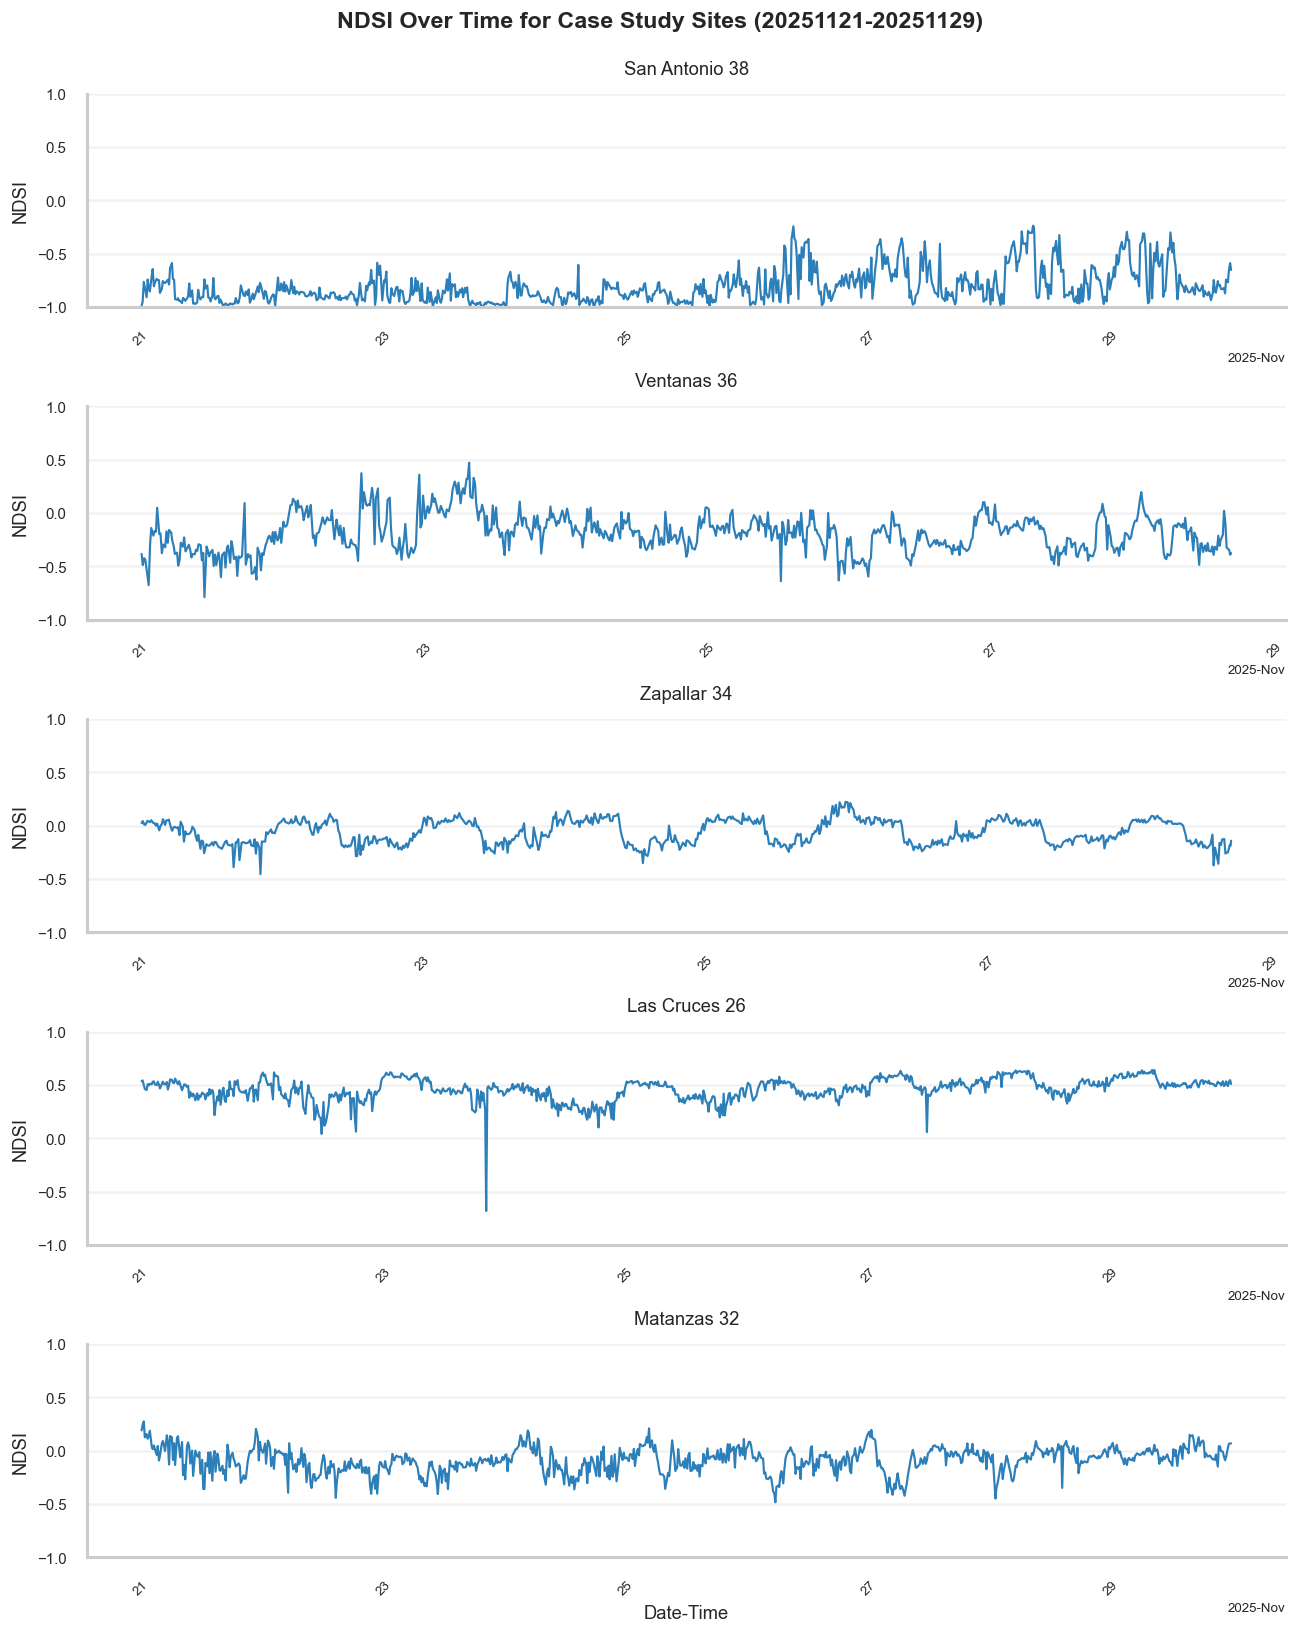

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/Graphs/ndsi_casestudies_20251121-20251129_anthro_500-2000_bio_2000-3000_anthro_energy.png


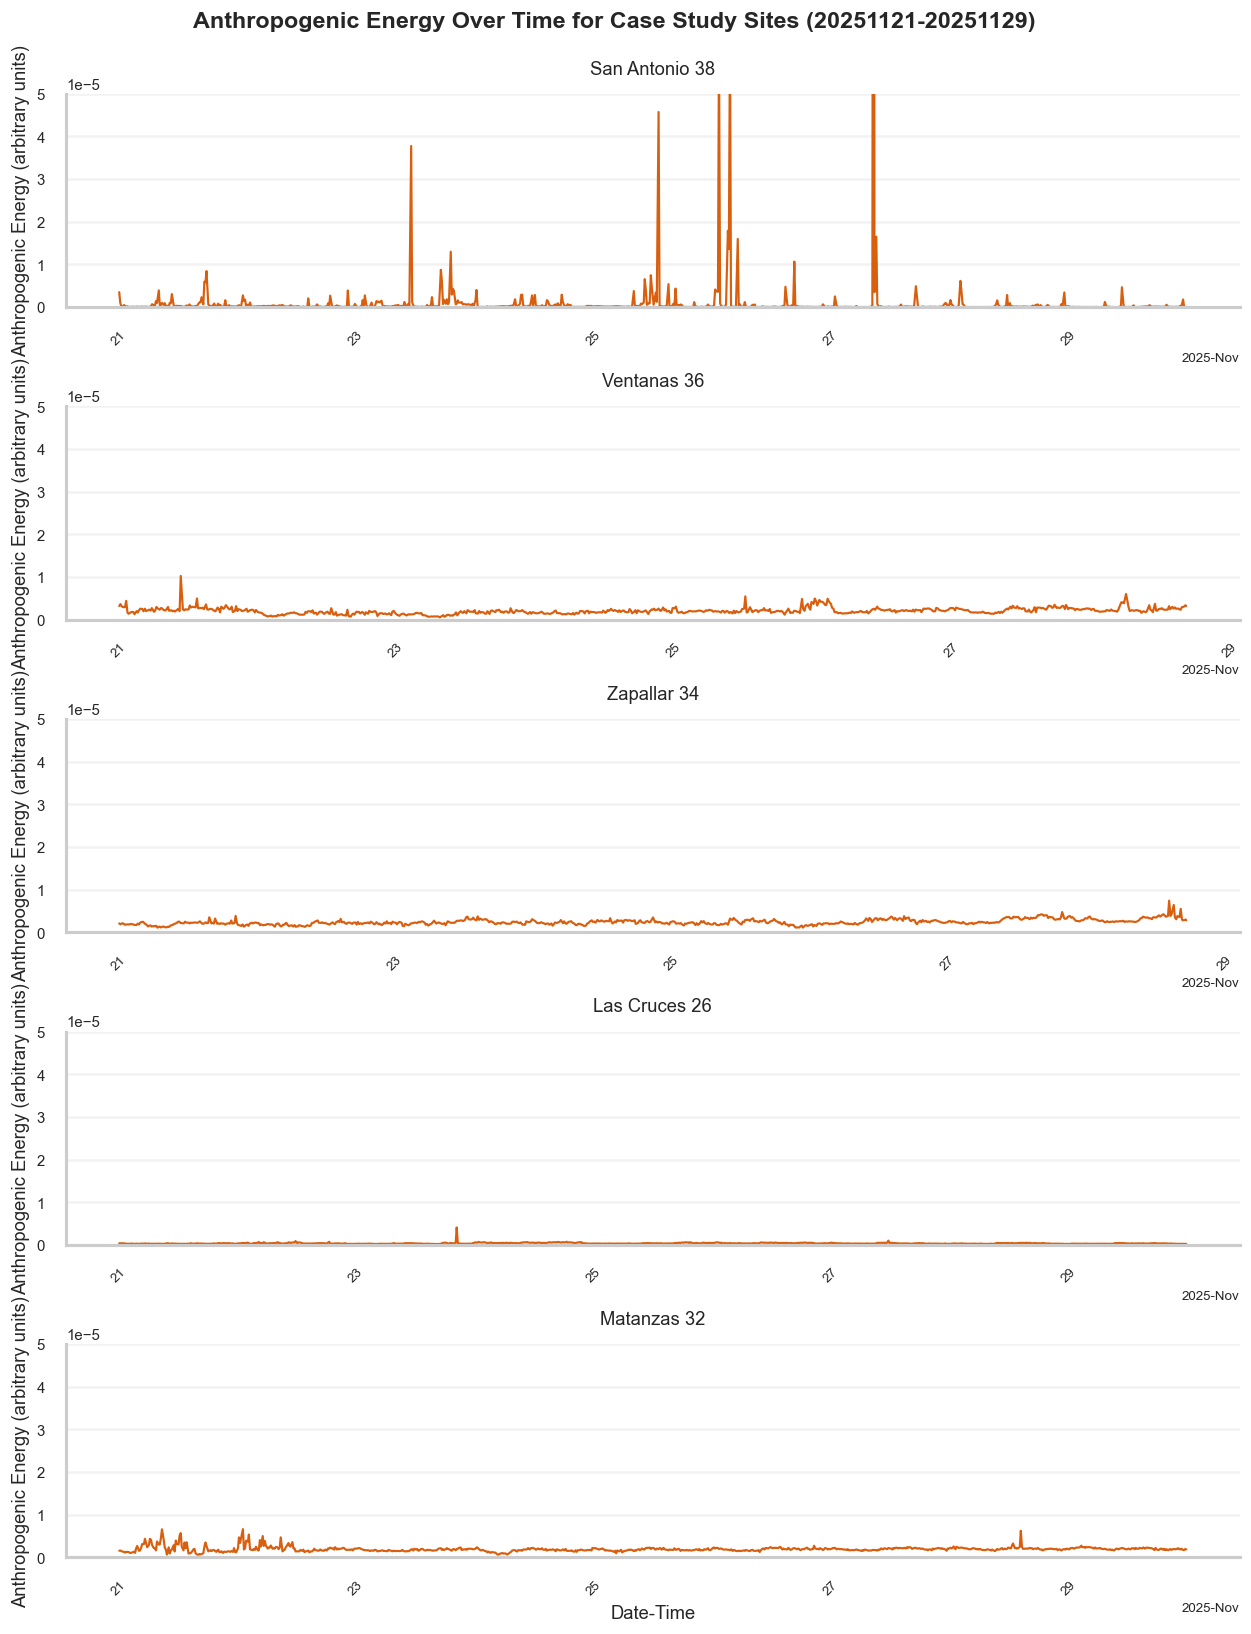

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/Graphs/ndsi_casestudies_20251121-20251129_anthro_500-2000_bio_2000-3000_bio_energy.png


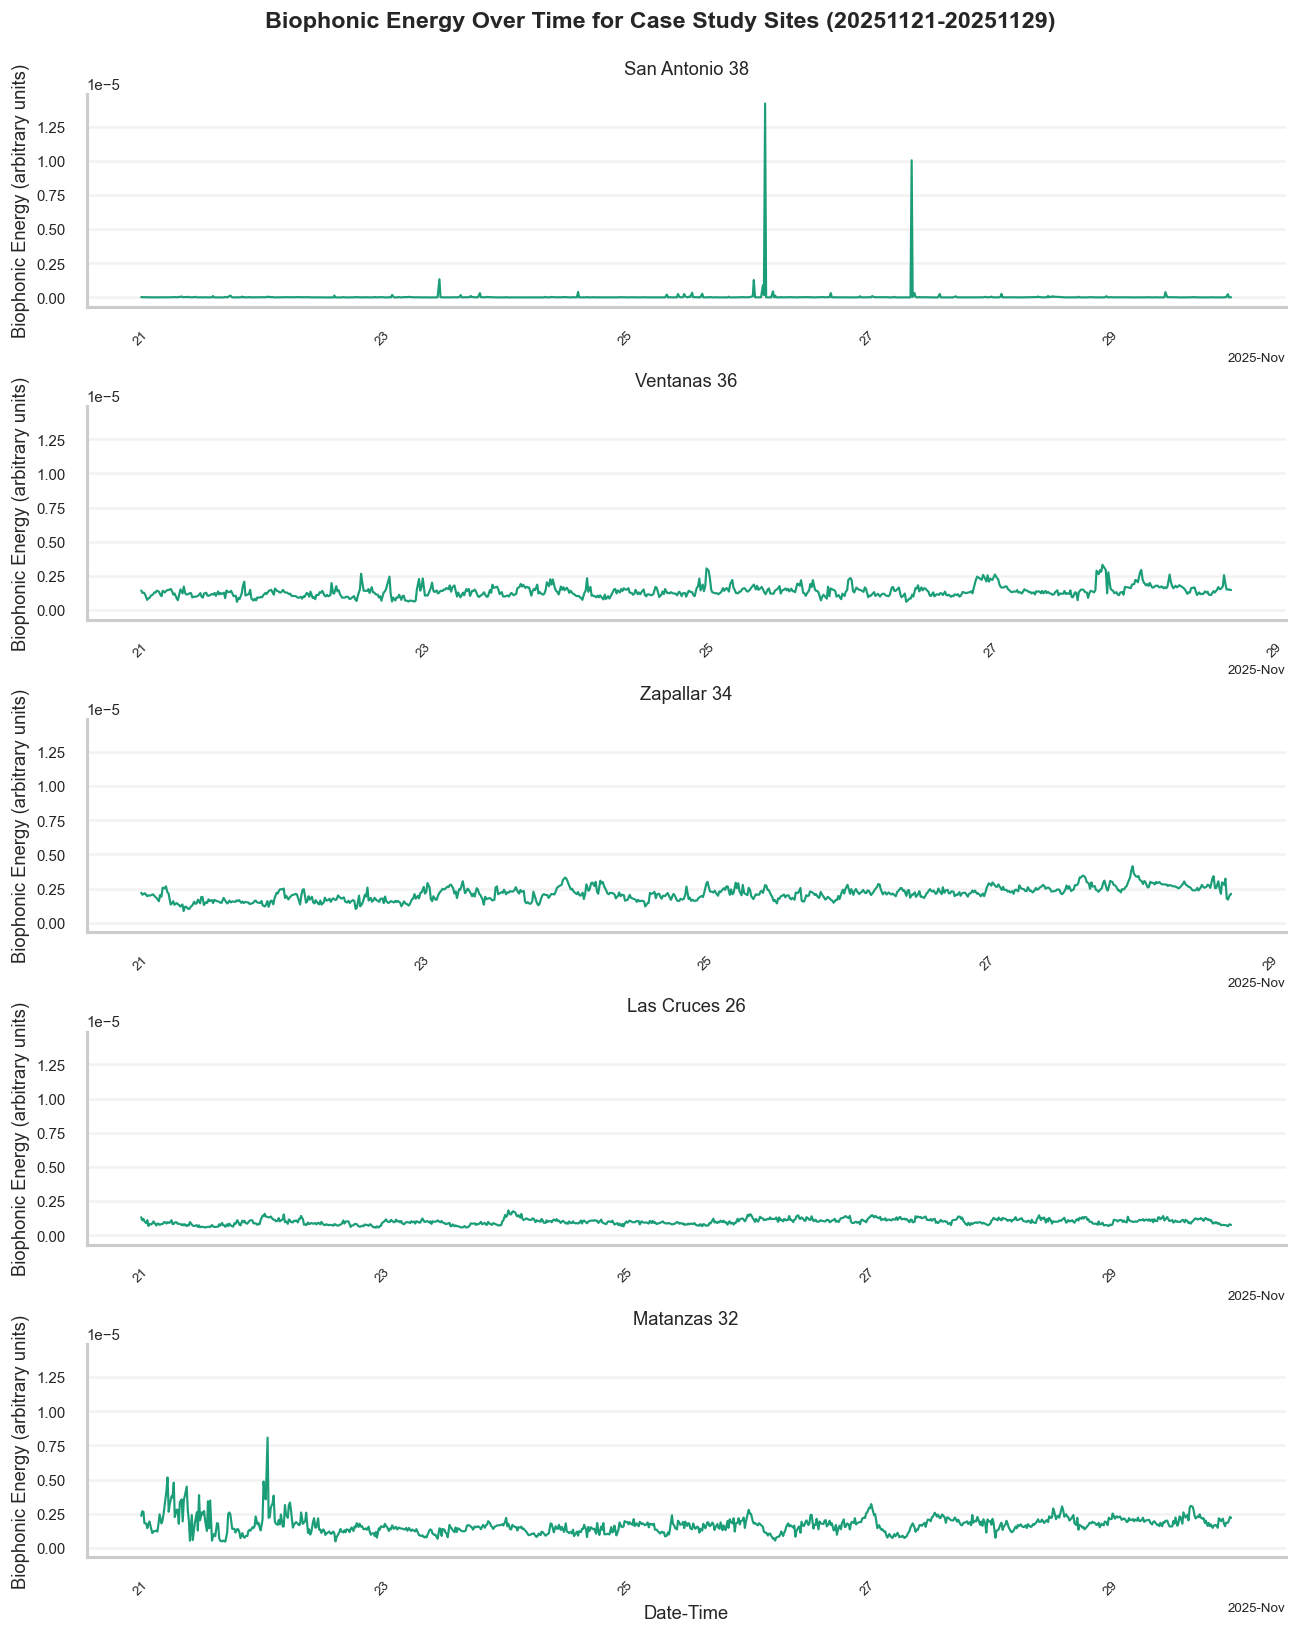

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/Graphs/ndsi_casestudies_20251121-20251129_anthro_500-2000_bio_2000-3000_summary_stats.csv
Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/Graphs/ndsi_casestudies_20251121-20251129_anthro_500-2000_bio_2000-3000_ndsi_quadrant_table.csv


In [ ]:
# PLOTS (save to disk) — Python equivalent of Plots.R

from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

# Make plots look nicer
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update(
    {
        "figure.dpi": 120,
        "savefig.dpi": 200,
        "axes.titlepad": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 9,
        "grid.alpha": 0.25,
    }
)

SHOW_PLOTS_INLINE = True

# Only use outputs from the analysis you just ran.
if "all_results" in globals() and isinstance(all_results, pd.DataFrame) and not all_results.empty:
    plot_data = all_results.copy()
elif "out_csv" in globals() and Path(out_csv).exists():
    plot_data = pd.read_csv(out_csv)
else:
    raise RuntimeError("No plot input found. Run the analysis cell first (it should create all_results and out_csv).")

required_cols = {"Site", "Time", "NDSI", "Anthro_Energy", "Bio_Energy"}
missing_cols = required_cols - set(plot_data.columns)
if missing_cols:
    raise RuntimeError(f"Missing columns for plotting: {sorted(missing_cols)}")

# Match Plots.R behavior: parse Time and keep Site order as encountered
plot_data["Time"] = pd.to_datetime(plot_data["Time"], utc=True, errors="coerce")
if plot_data["Time"].isna().any():
    plot_data["Time"] = pd.to_datetime(plot_data["Time"], errors="coerce")
if plot_data["Time"].isna().any():
    raise RuntimeError("Could not parse Time column for plotting")

site_order = list(pd.unique(plot_data["Site"].astype(str)))
plot_data["Site"] = pd.Categorical(plot_data["Site"].astype(str), categories=site_order, ordered=True)
plot_data = plot_data.sort_values(["Site", "Time"])

# Create Graphs folder like Plots.R
graphs_dir = Path(output_dir) / "Graphs"
graphs_dir.mkdir(parents=True, exist_ok=True)

# Build the same base name as the CSV output
if "out_csv" not in globals():
    raise RuntimeError("Expected out_csv to exist (created by the analysis cell).")
base = Path(out_csv).stem


def _finite_min_max(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce")
    s = s[np.isfinite(s)]
    if s.empty:
        return None
    return float(s.min()), float(s.max())


def _pad_limits(lims, pad_frac: float = 0.05):
    if lims is None:
        return None
    lo, hi = lims
    if not np.isfinite(lo) or not np.isfinite(hi):
        return None
    if lo == hi:
        eps = 1e-12 if lo == 0 else abs(lo) * 0.05
        return lo - eps, hi + eps
    pad = (hi - lo) * pad_frac
    return lo - pad, hi + pad


# Consistent y-axis ranges across all sites (per metric)
ndsi_ylim = (-1.0, 1.0)

# FIXED per your request
anthro_ylim = (0.0, 0.00005)

bio_ylim = _pad_limits(_finite_min_max(plot_data["Bio_Energy"]))

# ---------- Plots (facet per site) ----------

def _facet_timeseries(y_col: str, y_label: str, title: str, filename: str, ylim=None, color="#1f77b4"):
    g = sns.relplot(
        data=plot_data,
        x="Time",
        y=y_col,
        col="Site",
        col_wrap=1,
        kind="line",
        height=2.7,
        aspect=4.2,
        facet_kws=dict(sharex=False, sharey=True),
        linewidth=1.3,
        color=color,
    )
    g.set_axis_labels("Date-Time", y_label)
    g.set_titles("{col_name}")
    g.fig.suptitle(title, y=1.01, fontsize=14, fontweight="bold")

    for ax in g.axes.flat:
        # Nice datetime ticks
        locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
        ax.tick_params(axis="x", labelrotation=45)

        if ylim is not None:
            ax.set_ylim(ylim)

        # Slightly cleaner look
        ax.grid(True, axis="y")
        ax.grid(False, axis="x")

    out_path = graphs_dir / filename
    g.fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)

    if SHOW_PLOTS_INLINE:
        display(g.fig)

    plt.close(g.fig)


# Title suffix like Plots.R: only the date tag
_title_suffix = None
if "start_date" in globals() and "end_date" in globals() and start_date is not None and end_date is not None:
    _title_suffix = f"{start_date.strftime('%Y%m%d')}-{end_date.strftime('%Y%m%d')}"

suffix = f" ({_title_suffix})" if _title_suffix else ""

_facet_timeseries(
    y_col="NDSI",
    y_label="NDSI",
    title=f"NDSI Over Time for Case Study Sites{suffix}",
    filename=f"{base}_ndsi.png",
    ylim=ndsi_ylim,
    color="#2C7FB8",
)

_facet_timeseries(
    y_col="Anthro_Energy",
    y_label="Anthropogenic Energy (arbitrary units)",
    title=f"Anthropogenic Energy Over Time for Case Study Sites{suffix}",
    filename=f"{base}_anthro_energy.png",
    ylim=anthro_ylim,
    color="#D95F0E",
)

_facet_timeseries(
    y_col="Bio_Energy",
    y_label="Biophonic Energy (arbitrary units)",
    title=f"Biophonic Energy Over Time for Case Study Sites{suffix}",
    filename=f"{base}_bio_energy.png",
    ylim=bio_ylim,
    color="#1B9E77",
)

# ---------- Tables (same outputs as Plots.R) ----------
summary_stats_out = (
    plot_data.groupby("Site", as_index=False, observed=True)
    .agg(
        Segments=("NDSI", "size"),
        Mean_NDSI=("NDSI", "mean"),
        SD_NDSI=("NDSI", "std"),
        Mean_Anthro_Energy=("Anthro_Energy", "mean"),
        SD_Anthro_Energy=("Anthro_Energy", "std"),
        Mean_Bio_Energy=("Bio_Energy", "mean"),
        SD_Bio_Energy=("Bio_Energy", "std"),
    )
)

quadrant = plot_data.copy()
quadrant["NDSI_Quadrant"] = pd.cut(
    quadrant["NDSI"],
    bins=[-1.0000001, -0.5, 0.0, 0.5, 1.0000001],
    labels=["[-1, -0.5)", "[-0.5, 0]", "(0, 0.5)", "[0.5, 1]"],
    include_lowest=True,
)

# Avoid older pandas categorical groupby edge-cases by dropping NA first and grouping on strings.
quadrant = quadrant.dropna(subset=["NDSI_Quadrant"]).copy()
quadrant["NDSI_Quadrant"] = quadrant["NDSI_Quadrant"].astype(str)

ndsi_quadrant_table_out = (
    quadrant.groupby(["Site", "NDSI_Quadrant"], as_index=False, observed=True)
    .agg(Segments=("NDSI", "size"))
)
ndsi_quadrant_table_out["Total_Segments"] = ndsi_quadrant_table_out.groupby("Site", observed=True)["Segments"].transform("sum")
ndsi_quadrant_table_out["Percent_Time"] = 100.0 * ndsi_quadrant_table_out["Segments"] / ndsi_quadrant_table_out["Total_Segments"]

summary_path = graphs_dir / f"{base}_summary_stats.csv"
quadrant_path = graphs_dir / f"{base}_ndsi_quadrant_table.csv"

summary_stats_out.to_csv(summary_path, index=False)
ndsi_quadrant_table_out.to_csv(quadrant_path, index=False)

print("Saved:", summary_path)
print("Saved:", quadrant_path)
